# Solution

In [1]:
import openturns as ot

## Définition du modèle probabiliste
**Question 1:** Utiliser la classe `Uniform` et créer la variable `R` de loi Uniforme($\min=2.627\times 10^6$, $\max=3.392\times 10^6$). Dessiner la PDF de `R`.

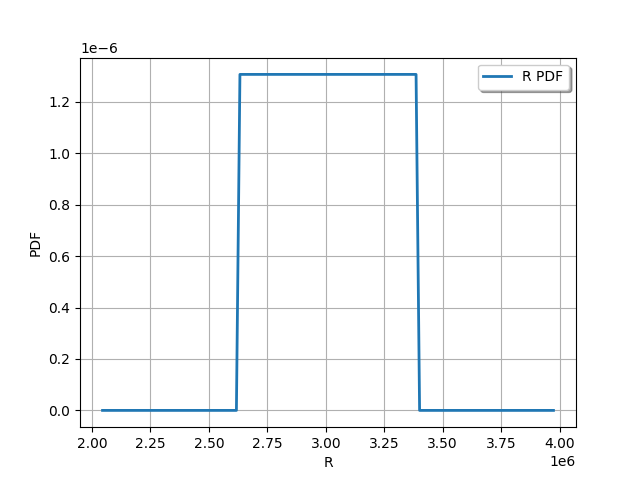

In [2]:
R = ot.Uniform(2.627e6,3.392e6)
R.setDescription("R")
R.drawPDF()

**Question 2:** Utiliser la classe `Normal` et créer la variable `S` de loi $\mathcal{N}(\mu_S=2.546\times 10^6, \sigma_S=0.09549\times 10^6)$. Dessiner la PDF de `S`.

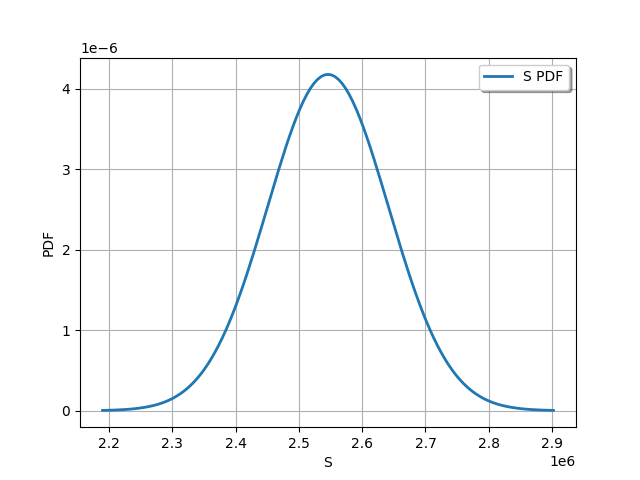

In [3]:
S = ot.Normal(2.546e6, 0.09549e6)
S.setDescription('S')
S.drawPDF()

## Définition de la fonction g
**Question 3:** Utiliser la classe `SymbolicFunction` pour définir la fonction `g`. 

In [4]:
g = ot.SymbolicFunction( ["R","S"],["R-S"])
g.setOutputDescription(["Y"])

In [5]:
g = ot.MemoizeFunction(g)

## Régression linéaire avec LinearLeastSquares
**Question 4:** Utiliser la classe `LinearLeastSquares` pour définir un modèle de régression linéaire. Quelle est la qualité du métamodèle linéaire ? Pourquoi ?

In [6]:
X = ot.ComposedDistribution([R, S])
n = 1000
sampleX = X.getSample(n)
sampleY = g(sampleX)

In [7]:
myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)

In [8]:
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()

In [13]:
Y_pred = responseSurface(sampleX)

# On valide en comparant Y (vrai) et Y_pred (prédit)
val = ot.MetaModelValidation(sampleY, Y_pred)
#val = ot.MetaModelValidation(sampleX, sampleY, responseSurface)

In [14]:


q2 = val.computeR2Score()
q2

class=Point name=Unnamed dimension=1 values=[1]

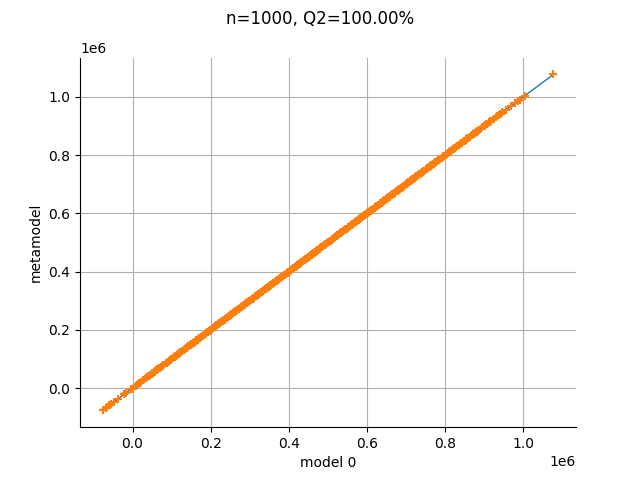

In [15]:
graph = val.drawValidation()
graph.setTitle("n=%d, Q2=%.2f%%" % (n,q2[0]*100))
graph

Puisque la fonction est *exactement* linéaire, le métamodèle linéaire est exact. 

## Estimation des indices SRC
**Question 5:** Estimer les indices SRC de la fonction `g` avec la classe `CorrelationAnalysis_SRC`. Qu'observez-vous ?

In [19]:
# 1. On instancie l'objet d'analyse avec les deux échantillons
analysis = ot.CorrelationAnalysis(sampleX, sampleY)

# 2. On appelle la méthode d'instance
src_indices = analysis.computeSRC()

# Affichage
print(src_indices)


[0.909137,-0.387144]


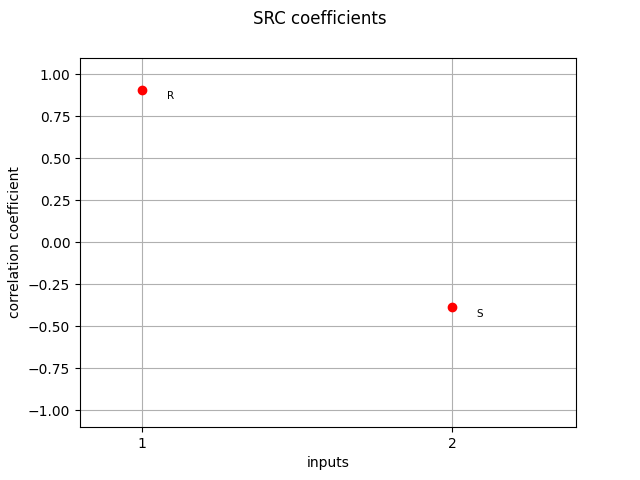

In [21]:
input_names = g.getInputDescription()
ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(src_indices, input_names, "SRC coefficients")

On observe que la variable $R$ est plus influente que la variable $S$, puisque son indice SRC est proche de 0.8. 

## Estimer les indices de Sobol' avec un algorithme incrémental
**Question 6:** Estimer les indices de Sobol' de la fonction `g` avec la classe `SobolSimulationAlgorithm`. Qu'observez-vous ?


In [22]:
alpha = 0.05 # i.e. 95% confidence interval
epsilon = 0.2 # Confidence interval length
blocksize = 50 # size of Sobol experiment at each iteration
batchsize = 16 # number of points evaluated simultaneously

In [24]:
estimator = ot.SaltelliSensitivityAlgorithm()
estimator.setUseAsymptoticDistribution(True)
algo = ot.SobolSimulationAlgorithm(X, g, estimator)
algo.setMaximumOuterSampling(100) # number of iterations
algo.setBlockSize(blocksize) 

algo.setIndexQuantileLevel(alpha) # alpha
algo.setIndexQuantileEpsilon(epsilon) # epsilon
algo.run()

In [25]:
result = algo.getResult()
fo = result.getFirstOrderIndicesEstimate()
to = result.getTotalOrderIndicesEstimate()
print("First order = %s" % (str(fo)))
print("Total order = %s" % (str(to)))

First order = [0.803162,0.127688]
Total order = [0.830627,0.188461]


In [26]:
def plotSobolSimulationResult(sobolSimulationResult,input_names,alpha=0.05):
    dist_fo = sobolSimulationResult.getFirstOrderIndicesDistribution()
    dist_to = sobolSimulationResult.getTotalOrderIndicesDistribution()
    dim = dist_to.getDimension()
    graph = ot.Graph("Sobol' sensivity indices","Inputs","Sensivity indices",True,"topright")
    # Indices
    curve = ot.Cloud(range(dim),fo)
    curve.setColor("red")
    curve.setLegend("First order")
    graph.add(curve)
    curve = ot.Cloud(range(dim),to)
    curve.setColor("blue")
    curve.setLegend("Total order")
    graph.add(curve)
    # Labels
    x = ot.Point(range(dim)) + ot.Point([0.1]*dim)
    text = ot.Text(x, to, input_names)
    text.setColor("black")
    graph.add(text)
    # Error bars
    for i in range(dim):
        dist_fo_i = dist_fo.getMarginal(i)
        dist_to_i = dist_to.getMarginal(i)
        fo_ci = dist_fo_i.computeBilateralConfidenceInterval(1-alpha)
        to_ci = dist_to_i.computeBilateralConfidenceInterval(1-alpha)
        fo_a = fo_ci.getLowerBound()[0]
        fo_b = fo_ci.getUpperBound()[0]
        to_a = to_ci.getLowerBound()[0]
        to_b = to_ci.getUpperBound()[0]
        curve = ot.Curve([i,i],[fo_a,fo_b])
        curve.setColor("red")
        graph.add(curve)
        curve = ot.Curve([i,i],[to_a,to_b])
        curve.setColor("blue")
        graph.add(curve)
    return graph

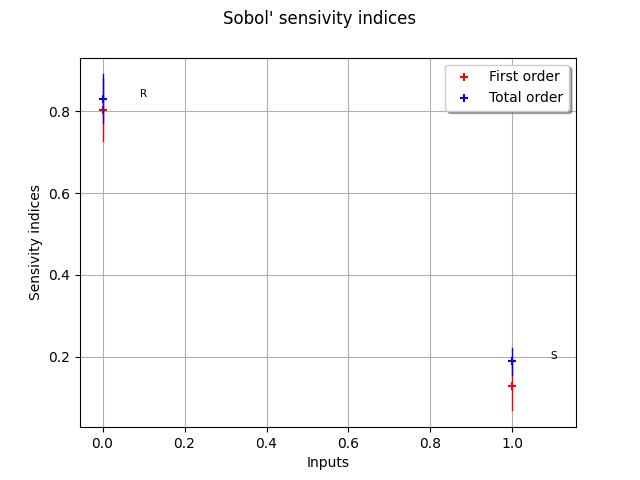

In [27]:
inputDescription = g.getInputDescription()
plotSobolSimulationResult(result,inputDescription)

On trouve des résultats similaires aux résultats que l'on avait obtenus avec les indices SRC.

## Amélioration du calcul
**Question 7:** Pourriez-vous améliorer la précision d'estimation des indices de sensibilité dans ce cas particulier ?

Ici on a déjà un modèle linéaire de base. En le linéarisant on ne pourra pas faire mieux que cela.

La fonction $g$ est une fonction linéaire puisque :

$$
g(R,S) = \beta_0 + \beta_1 R + \beta_2 S,
$$

pour tout $R,S\in\mathbb{R}$ avec $\beta_0 = 0$, $\beta_1=1$ et $\beta_2=-1$.

La variance de $Y$ est :

$$
V(Y) = \beta_1^2 V(R) + \beta_2^2 V(S),
$$

puisque les variables $R$ et $S$ sont indépendantes. 

Par conséquent, les indices SRC du modèle sont :

$$
SRC_R = \frac{\beta_1^2 V(R)}{V(Y)}, \qquad 
SRC_S = \frac{\beta_2^2 V(S)}{V(Y)}.
$$



In [28]:
beta = ot.Point(3)
beta[0] = 0.0
beta[1] = 1.0
beta[2] = -1.0

In [29]:
VR = R.getCovariance()[0,0]
VR

48768750000.0

In [30]:
VS = S.getCovariance()[0,0]
VS

9118340100.0

Pour calculer la variance de $Y$, on pourrait utiliser l'expression exacte. Toutefois, puisque la librairie permet de calculer directement la variance, nous réalisons le calcul grâce à l'arithmétique des distributions.

In [31]:
Y = R - S

In [32]:
VY = Y.getCovariance()[0,0]
VY

57887090100.0

In [24]:
SRC = ot.Point(2)
SRC[0] = beta[1]**2 * VR / VY
SRC[1] = beta[2]**2 * VS / VY
SRC

class=Point name=Unnamed dimension=2 values=[0.842481,0.157519]